In [2]:
import b3d
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from b3d import Pose, Mesh
import rerun as rr

In [41]:
b3d.rr_init()

In [26]:
import importlib
importlib.reload(b3d.mesh)
importlib.reload(b3d.io.data_loader)
importlib.reload(b3d.utils)
importlib.reload(b3d.renderer.renderer_original)

<module 'b3d.renderer.renderer_original' from '/home/nishadgothoskar/b3d/b3d/renderer/renderer_original.py'>

100%|██████████| 39/39 [00:13<00:00,  2.80it/s]


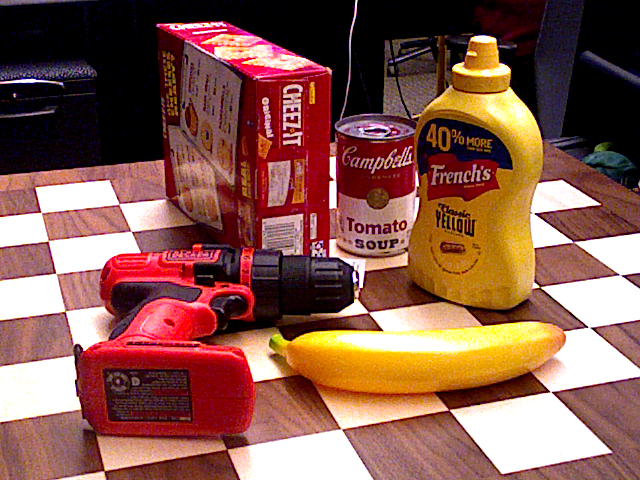

In [92]:
import os
type = "ycbv"
if type == "ycbv":
    ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
    all_data = b3d.io.get_ycbv_test_images(ycb_dir, 50, range(1,1950,50))
elif type == "ycbineaot":
    videoname = "mustard0"
    ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
    video_dir = os.path.join(b3d.get_assets_path(), f"ycbineoat")
    all_data = b3d.io.data_loader.get_ycbineoat_images(
        video_dir, videoname, range(1, 600, 6)
    )
b3d.viz_rgb(all_data[-1]["rgbd"][...,:3])

In [93]:
meshes = [
    Mesh.from_obj_file(os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')).scale(0.001)
    for id in all_data[0]["object_types"]
]

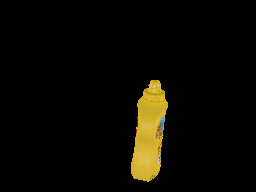

In [96]:
height, width = all_data[0]["rgbd"].shape[:2]
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
scaling_factor = 0.4
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)
IDX = 2
camera_pose = all_data[0]["camera_pose"]
object_poses = all_data[0]["object_poses"]
meshes[IDX].rr_visualize("mesh")
mesh_at_pose = meshes[IDX]
mesh_at_pose = mesh_at_pose.transform(camera_pose.inv() @ object_poses[IDX])
rgbd = renderer.render_rgbd(
    mesh_at_pose.vertices,
    mesh_at_pose.faces,
    mesh_at_pose.vertex_attributes,
)
b3d.viz_rgb(rgbd[...,:3])

In [97]:
import genjax
from b3d.modeling_utils import uniform_discrete, uniform_pose
from collections import namedtuple
from genjax import Pytree
import b3d
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from b3d import Pose, Mesh
import rerun as rr

DenseImageLikelihoodArgs = namedtuple('DenseImageLikelihoodArgs', [
    'color_tolerance',
    'depth_tolerance',
    'inlier_score',
    'outlier_prob',
    'multiplier',
])


def get_rgb_depth_inliers_from_observed_rendered_args(observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args):
    observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)
    error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (error < model_args.color_tolerance) * valid_data_mask
    depth_inliers = (jnp.abs(observed_depth - rendered_depth) < model_args.depth_tolerance) * valid_data_mask
    inliers = color_inliers * depth_inliers
    outliers = jnp.logical_not(inliers) * valid_data_mask
    undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)
    return (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask)


def likelihood_intermediate_results(observed_rgbd, rendered_rgbd, likelihood_args):
    (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = get_rgb_depth_inliers_from_observed_rendered_args(
        observed_rgbd[...,:3],
        rendered_rgbd[...,:3],
        observed_rgbd[...,3],
        rendered_rgbd[...,3],
        likelihood_args
    )

    inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask = get_rgb_depth_inliers_from_observed_rendered_args(
        observed_rgbd[...,:3],
        rendered_rgbd[...,:3],
        observed_rgbd[...,3],
        rendered_rgbd[...,3],
        likelihood_args
    )

    inlier_score = likelihood_args.inlier_score
    outlier_prob = likelihood_args.outlier_prob
    multiplier = likelihood_args.multiplier

    rendered_depth = rendered_rgbd[...,3]
    observed_depth = observed_rgbd[...,3]
    observed_depth_corrected = observed_depth + (observed_depth == 0.0) * renderer.far

    rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)
    observed_areas = (observed_depth_corrected / fx) * (observed_depth_corrected / fy)

    inlier_contribution = jnp.sum(inlier_score *  inliers * rendered_areas)
    V = 1/3 * jnp.power(renderer.far, 3) * renderer.width * renderer.height * 1/(fx * fy)
    outlier_contribution_teleporation = jnp.sum(outliers * observed_areas / V * 0.001 * outlier_prob * (observed_depth > rendered_depth))
    outlier_contribution_not_teleportation = jnp.sum(outliers * observed_areas / V * outlier_prob * (observed_depth <= rendered_depth))

    final_log_score =  jnp.log(inlier_contribution + outlier_contribution_teleporation + outlier_contribution_not_teleportation) * multiplier

    return {
        "inliers": inliers,
        "color_inliers": color_inliers,
        "depth_inliers": depth_inliers,
        "outliers": outliers,
        "undecided": undecided,
        "valid_data_mask": valid_data_mask,
        "inlier_contribution": inlier_contribution,
        "outlier_contribution": outlier_contribution_not_teleportation,
        "undecided_contribution": outlier_contribution_teleporation,
        "final_log_score": final_log_score
    }

@Pytree.dataclass
class DenseImageLikelihood(genjax.ExactDensity):
    def sample(self, key, rendered_rgbd, likelihood_args):
        return rendered_rgbd

    def logpdf(self, observed_rgbd, rendered_rgbd, likelihood_args):
        results = likelihood_intermediate_results(observed_rgbd, rendered_rgbd, likelihood_args)
        return results["final_log_score"]
    
dense_image_likelihood = DenseImageLikelihood()


@genjax.gen
def dense_multiobject_model(num_objects, meshes, dense_likelihood_args):

    all_poses = []
    for i in range(num_objects.const):
        object_pose = uniform_pose(jnp.ones(3)*-100.0, jnp.ones(3)*100.0) @ f"object_pose_{i}"
        all_poses.append(object_pose)

    all_poses = Pose.stack_poses(all_poses)
    scene_mesh = Mesh.transform_and_merge_meshes(meshes, all_poses)
    noiseless_rendered_rgbd = renderer.render_rgbd(
        scene_mesh.vertices,
        scene_mesh.faces,
        scene_mesh.vertex_attributes,
    )
    image = dense_image_likelihood(noiseless_rendered_rgbd, dense_likelihood_args) @ "image"
    return {"object_poses": all_poses, "rendered_image": noiseless_rendered_rgbd, "image": image}

importance_jit = jax.jit(dense_multiobject_model.importance)

In [98]:
def _gvmf_and_select_best_move(trace, key, variance, concentration, address, number):
    addr = address.const
    test_poses = Pose.concatenate_poses(
        [
            jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0, None, None, None))(
                jax.random.split(key, number), trace.get_choices()[addr], variance, concentration
            ),
            trace.get_choices()[addr][None,...]
        ]
    )
    test_poses_batches = test_poses.split(10)
    scores = jnp.concatenate(
        [
            b3d.enumerate_choices_get_scores(
                trace, key, (addr,), poses
            )
            for poses in test_poses_batches
        ]
    )
    trace = b3d.update_choices(
        trace,
        jax.random.PRNGKey(0),
        (addr,),
        test_poses[scores.argmax()],
    )
    key = jax.random.split(key, 2)[-1]
    return trace, key


gvmf_and_select_best_move = jax.jit(_gvmf_and_select_best_move, static_argnames=["address", "number"])


def rerun_visualize_trace_t(trace, t, modes=["rgb", "inliers"]):
    observed_rgbd = trace.get_retval()["image"]
    rendered_rgbd = trace.get_retval()["rendered_image"]
    likelihood_args = trace.get_args()[2]

    rr.set_time_sequence("frame", t)

    if "rgb" in modes:
        rr.log("rgb", rr.Image(observed_rgbd[...,:3]))
        rr.log("rgb/rendering", rr.Image(rendered_rgbd[...,:3]))

    # if "depth" in modes:
    #     rr.log("/image/depth/", rr.DepthImage(observed_rgbd[...,3]))
    #     rr.log("/image/depth/rendering", rr.DepthImage(rendered_rgbd[...,3]))

    info_string = f"# Score : {trace.get_score()}"

    if "inliers" in modes:
        (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = get_rgb_depth_inliers_from_observed_rendered_args(
            observed_rgbd[...,:3],
            rendered_rgbd[...,:3],
            observed_rgbd[...,3],
            rendered_rgbd[...,3],
            likelihood_args
        )
        rr.log("/rgb/overlay/inliers", rr.DepthImage(inliers * 1.0))
        rr.log("/rgb/overlay/outliers", rr.DepthImage(outliers * 1.0))
        rr.log("/rgb/overlay/undecided", rr.DepthImage(undecided * 1.0))
        info_string += f"\n # Inliers : {jnp.sum(inliers)}"
        info_string += f"\n # Outliers : {jnp.sum(outliers)}"
        info_string += f"\n # Undecided : {jnp.sum(undecided)}"
    rr.log("/info", rr.TextDocument(info_string))


In [99]:

# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
# Gridding on translation only.
translation_deltas = Pose.concatenate_poses(
    [
        jax.vmap(lambda p: Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    jnp.linspace(-0.03, 0.03, 11),
                    jnp.linspace(-0.03, 0.03, 11),
                    jnp.linspace(-0.03, 0.03, 11),
                ),
                axis=-1,
            ).reshape(-1, 3)
        ),
        Pose.identity()[None, ...],
    ]
)
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses(
    [
        jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0, None, None, None))(
            jax.random.split(jax.random.PRNGKey(0), 11 * 11 * 11),
            Pose.identity(),
            0.00001,
            1000.0,
        ),
        Pose.identity()[None, ...],
    ]
)
all_deltas = Pose.stack_poses([translation_deltas, rotation_deltas])


In [154]:
rr.set_time_sequence("frame", 0 )
IDX  = 1
color_error, depth_error = (60.0, 0.01)
inlier_score, outlier_prob = (4.0, 0.001)
color_multiplier, depth_multiplier = (10000.0, 500.0)
dense_likelihood_args = DenseImageLikelihoodArgs(
    color_error,
    depth_error,
    inlier_score,
    outlier_prob,
    color_multiplier,
)
pose = Pose.sample_gaussian_vmf_pose(jax.random.PRNGKey(10), camera_pose.inv() @ object_poses[IDX], 0.001, 1000000.0)
trace, _ = importance_jit(
    jax.random.PRNGKey(2),
    genjax.ChoiceMap.d(
        dict(
            [
                ("object_pose_0",  pose),
                ("image", 
                    jax.image.resize(
                        all_data[0]["rgbd"], (renderer.height, renderer.width, 4), method="nearest"
                    ) 
                )
            ]
        )
    ),
    (Pytree.const(1), [meshes[IDX]], dense_likelihood_args),
)
trace0 = trace
rerun_visualize_trace_t(trace, 0, modes=["rgb", "inliers"])

In [155]:
from tqdm import tqdm
trace = trace0
traces = []
for t in tqdm(range(len(all_data))):
    trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("image",), jax.image.resize(
        all_data[t]["rgbd"], (renderer.height, renderer.width, 4), method="nearest"
    ))

    trace, key = gvmf_and_select_best_move(trace, key, 0.02, 500.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.01, 1000.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.005, 1000.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.001, 2000.0, Pytree.const("object_pose_0"), 200)

    traces.append(trace)
    rerun_visualize_trace_t(trace, t, modes=["rgb", "inliers"])

100%|██████████| 39/39 [00:05<00:00,  6.81it/s]


In [151]:
b3d.make_video_from_pil_images(
    [
        b3d.multi_panel(
            [
                b3d.viz_rgb(trace.get_retval()["image"][...,:3]),
                b3d.viz_rgb(trace.get_retval()["rendered_image"][...,:3]),
                b3d.overlay_image(
                    b3d.viz_rgb(trace.get_retval()["image"][...,:3]),
                    b3d.viz_rgb(trace.get_retval()["rendered_image"][...,:3])
                )
            ],
            labels=["Observed", "Inferred", "Overlay"]
        )
        for trace in traces
    ],
    f"OBJECT_{IDX}_TRACKING.mp4"
)


In [82]:
t = 14
trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("image", "object_pose_0"), jax.image.resize(
    all_data[t]["rgbd"], (renderer.height, renderer.width, 4), method="nearest"
), all_data[t]["camera_pose"].inv() @ all_data[t]["object_poses"][IDX])

rerun_visualize_trace_t(trace, t, modes=["rgb", "inliers"])

In [83]:
trace, key = b3d.bayes3d.enumerative_proposals.enumerate_and_select_best_move(
    trace, ("object_pose_0",), key, all_deltas
)
rerun_visualize_trace_t(trace, t, modes=["rgb", "inliers"])


In [77]:
for _ in range(10):
    trace, key = gvmf_and_select_best_move(trace, key, 0.02, 500.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.01, 1000.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.005, 2000.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.001, 2000.0, Pytree.const("object_pose_0"), 200)
print(trace.get_score())
rerun_visualize_trace_t(trace, t, modes=["rgb", "inliers"])

-37241.582
